id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
('2017-08-23',)
2016-08-23


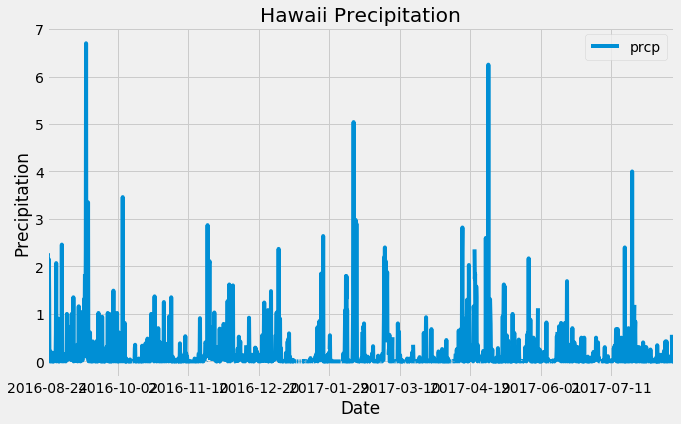

In [191]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Inspect Tables (Measurement)
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

# Inspect Tables (Station)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

# Choose Start and End Date for Trip
start_date = dt.date(2019, 12, 15)
end_date = dt.date(2019, 12, 21)

# Find last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Find End Date
end_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(end_date)

# Pull Last Year of Precipitation Data
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > end_date).\
    order_by(Measurement.date).all()

# Put Last Year of Precipitation Data into Pandas DataFrame
precipitation_df = pd.DataFrame(prcp_data)
precipitation_df.head()

# Set Index to Date
precipitation_df = precipitation_df.set_index('date')
precipitation_df.head()

# Plot DataFrame
fig, ax = plt.subplots(figsize = (10, 6))
precipitation_df.plot(ax = ax)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_title("Hawaii Precipitation")
plt.savefig("Images/Hawaiiprecipitation.png")

<Figure size 432x288 with 0 Axes>

9


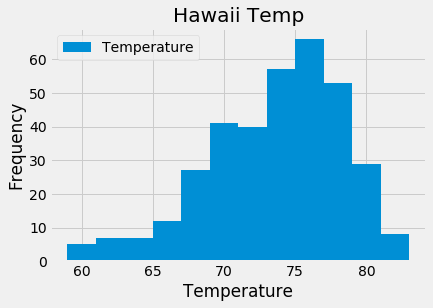

In [189]:
#plot figure
plt.tight_layout()
plt.show()

# Summary of statistics for Precipitation DataFrame
precipitation_df.describe()

# Design a query to show how many stations are available in this dataset?
distinct_stations = session.query(Station.id).distinct().count()
print(distinct_stations)

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
summary_temps

# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_year_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Put into DataFrame
active_year_temp_df = pd.DataFrame(active_year_temp)
active_year_temp_df.rename(columns = {'date':'Date','tobs':'Temperature'}, inplace=True)
active_year_temp_df.set_index(['Date'], inplace=True)
active_year_temp_df.head()

# Plot Histogram
fig, ax = plt.subplots()
active_year_temp_df.plot.hist(bins = 12, ax = ax)
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.set_title("Hawaii Temp")
plt.savefig("Images/HawaiiTemp.png")
plt.show()